In [1]:
%load_ext autoreload
%autoreload 2

In [181]:
import generative as gen
import numpy as np
import matplotlib.pyplot as plt
import scipy
import networkx as nx
from tqdm import tqdm
from scipy.spatial.distance import pdist, squareform
from utils import NetworkOptimizer, fast_evaluator, density_distance

In [75]:
data = np.loadtxt('datasets/macaque_modha/conn.csv', delimiter=',').astype(bool)
data = (data + data.T)/2 > 0
coordinates = np.loadtxt('datasets/macaque_modha/coords.csv', delimiter=',')
macaque_euclidean_dist = squareform(pdist(coordinates))

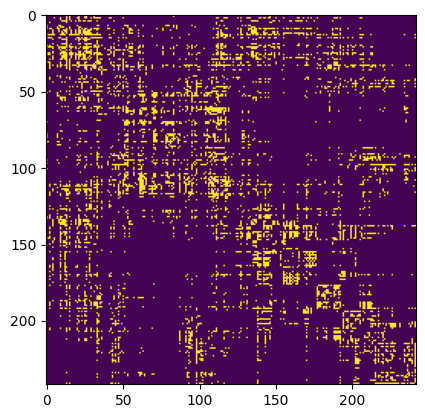

In [76]:
plt.imshow(data)

In [3]:
celegans = scipy.io.loadmat(
    "datasets/celegans277.mat",
    simplify_cells=True,
    squeeze_me=True,
    chars_as_strings=True,
)

In [35]:
celegans_connectome = celegans["celegans277matrix"]
# Make undirected by adding the matrix with its transpose
celegans_connectome = (celegans_connectome + celegans_connectome.T)/2 > 0
celegans_coordinates = celegans["celegans277positions"]
celegans_euc_dist = squareform(pdist(celegans_coordinates))

array([[False, False,  True, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [ True, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

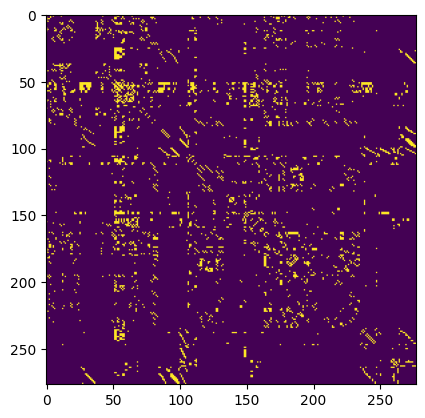

In [36]:
plt.imshow(celegans_connectome)

In [3]:
res_parcellation = 0
consensus_mat = scipy.io.loadmat(
    "datasets/Consensus_Connectomes.mat",
    simplify_cells=True,
    squeeze_me=True,
    chars_as_strings=True,
)
connectivity = consensus_mat["LauConsensus"]["Matrices"][res_parcellation][0].astype(bool)
coordinates = consensus_mat["LauConsensus"]["Matrices"][res_parcellation][3]
euclidean_dis = squareform(pdist(coordinates, metric='euclidean'))

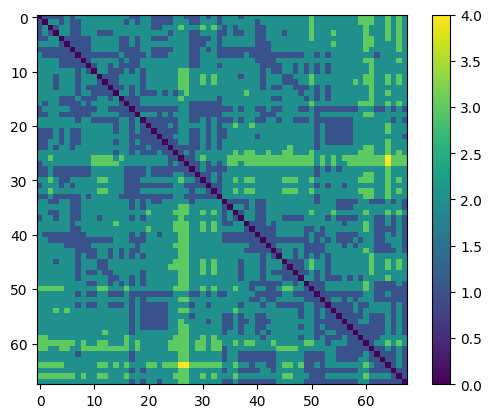

In [10]:
plt.imshow(gen.shortest_path_distance(connectivity, coordinates))
plt.colorbar()

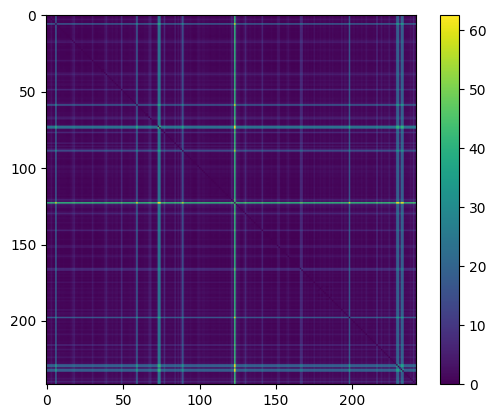

In [195]:
plt.imshow(gen.resistance_distance(data, coordinates))
plt.colorbar()

In [194]:
plt.imshow(gen.propagation_distance(data, coordinates))
plt.colorbar()

ValueError: eigvals() argument must not cause a domain change.

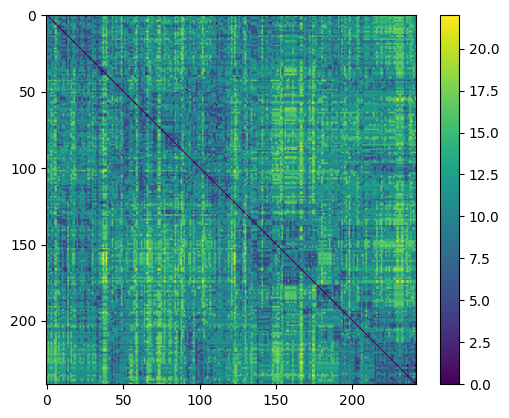

In [192]:
plt.imshow(gen.search_information(data, coordinates))
plt.colorbar()

In [92]:
from scipy.special import rel_entr

In [159]:
from numba import njit
@njit
def kl_divergence(synthetic, empirical):
    synthetic = synthetic.ravel() + 1e-10
    empirical = empirical.ravel() + 1e-10
    
    synthetic /= np.sum(synthetic)
    empirical /= np.sum(empirical)
    
    kl_div = 0.0
    for i in range(len(synthetic)):
        if synthetic[i] > 0:
            kl_div += synthetic[i] * np.log(synthetic[i] / empirical[i])
    return kl_div

In [218]:
optimizer = NetworkOptimizer(
        coordinates=coordinates,
        empirical_network=data,
        n_iterations=2500,
        random_seed=11,
        distance_fn=gen.shortest_path_distance,
        evaluator=density_distance,
    )
    
# Define parameter ranges
param_ranges = {
    'alpha': (0.1, 10),
    'beta': (0.1, 10),
}

# Run optimization
results = optimizer.optimize(
    param_ranges=param_ranges,
    n_calls=50,
    n_parallel_samples=1,
    verbose=True,
    acquisition_function='EI',
)

Running Bayesian optimization...


Simulating network evolution: 100%|██████████| 2499/2499 [01:40<00:00, 24.85it/s]


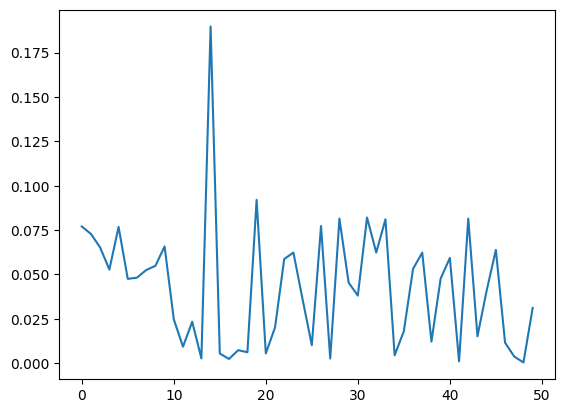

In [219]:
plt.plot(results.all_scores);

In [220]:
results.best_parameters

{'alpha': 9.985578887732997, 'beta': 1.8853048453857346}

In [283]:

# Create parameter trajectories
n_iterations = 20_000
n_nodes = data.shape[0]
alpha = np.full(n_iterations, results.best_parameters["alpha"])
beta = np.full(n_iterations, results.best_parameters["beta"])
noise = np.zeros(n_iterations)
penalty = np.zeros(n_iterations)

# Run simulation
history = gen.simulate_network_evolution(
    coordinates=coordinates,
    n_iterations=n_iterations,
    alpha=alpha,
    beta=beta,
    noise=noise,
    distance_fn=gen.shortest_path_distance,
    connectivity_penalty=penalty,
    n_jobs=-1,  # Use all available cores
    random_seed=11,
    batch_size=32,
)

Simulating network evolution: 100%|██████████| 19999/19999 [18:00<00:00, 18.50it/s]


In [284]:
np.sum(history[:,:,-1])/(data.shape[0])**2

0.10989686496823987

In [285]:
np.sum(data)/(data.shape[0])**2

0.1042961546342463

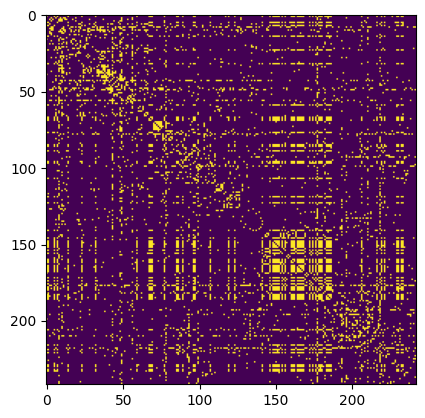

In [286]:
plt.imshow(history[:,:,-1])

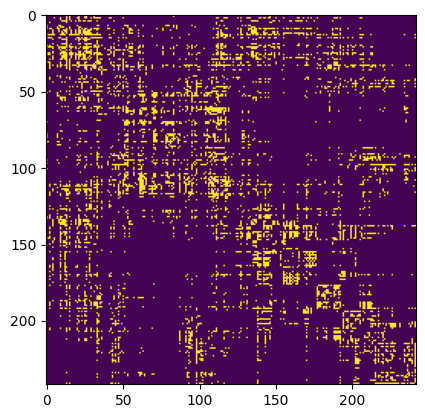

In [275]:
plt.imshow(data)

In [287]:
p = (data.flatten() + 1e-10)/np.sum(data.flatten() + 1e-10)
q = (history[:,:,-1].flatten() + 1e-10)/np.sum(history[:,:,-1].flatten() + 1e-10)
rel_entr(p, q).sum()

20.575021060813917

In [288]:
energy_vector = np.zeros(history.shape[2])
clustering_vector = np.zeros(history.shape[2])
betweenness_vector = np.zeros(history.shape[2])
distance_vector = np.zeros(history.shape[2])
degrees_vector = np.zeros(history.shape[2])
for t in tqdm(range(history.shape[2]), desc="Evaluating network evolution"):
    res = fast_evaluator(history[:,:,t], data, macaque_euclidean_dist)
    energy_vector[t] = res["energy"]
    clustering_vector[t] = res["ks_clustering"]
    betweenness_vector[t] = res["ks_betweenness"]
    distance_vector[t] = res["ks_distance"]
    degrees_vector[t] = res["ks_degrees"]

Evaluating network evolution: 100%|██████████| 20000/20000 [37:46<00:00,  8.83it/s]


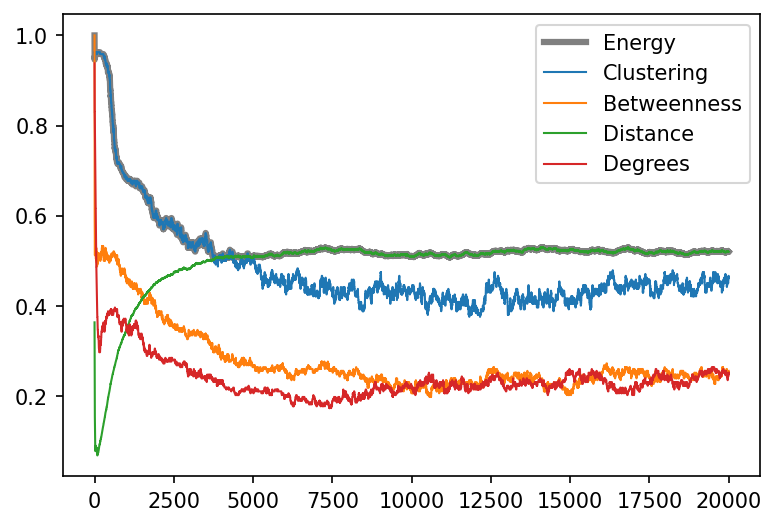

In [289]:
plt.figure(figsize=(6, 4),dpi=150)
plt.plot(energy_vector,lw=3,label='Energy',color='gray')
plt.plot(clustering_vector,lw=1,label='Clustering')
plt.plot(betweenness_vector,lw=1,label='Betweenness')
plt.plot(distance_vector,lw=1,label='Distance')
plt.plot(degrees_vector,lw=1,label='Degrees')
plt.legend();

In [290]:
np.min(energy_vector)

0.5037744737091552

In [291]:
np.argmin(energy_vector)

3768

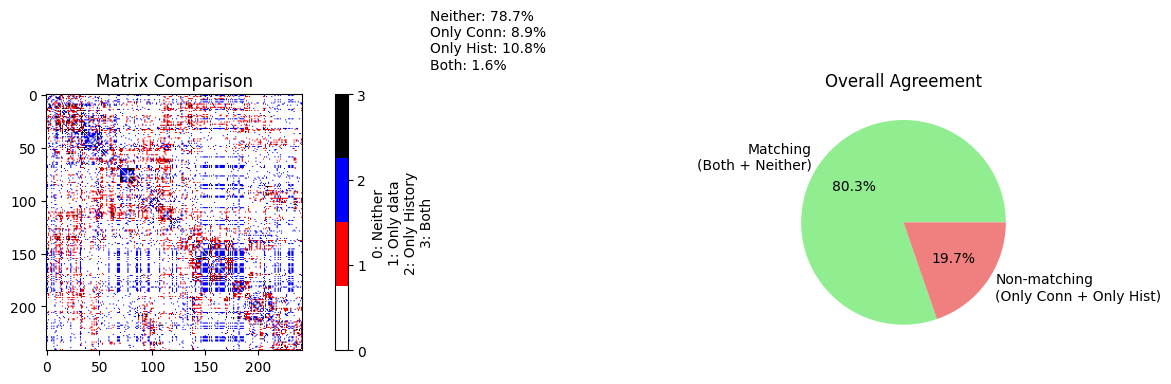

In [292]:
# Create a figure
plt.figure(figsize=(15, 4))

# Get the time point with minimum energy
min_energy_point = energy_vector.argmin()

# Create subplots
plt.subplot(121)
# Create a custom matrix where:
# 0: neither (white)
# 1: only data (red)
# 2: only history (blue)
# 3: both (black)
comparison = data.astype(int) + 2 * history[:,:,min_energy_point].astype(int)
plt.imshow(comparison, cmap=plt.cm.colors.ListedColormap(['white', 'red', 'blue', 'black']))
plt.title('Matrix Comparison')
plt.colorbar(ticks=[0, 1, 2, 3], 
            label='0: Neither\n1: Only data\n2: Only History\n3: Both')

# Add percentage text
total = data.shape[0] * data.shape[1]
neither = np.sum(comparison == 0) / total * 100
only_conn = np.sum(comparison == 1) / total * 100
only_hist = np.sum(comparison == 2) / total * 100
both = np.sum(comparison == 3) / total * 100

plt.text(1.5, 1.1, f'Neither: {neither:.1f}%\nOnly Conn: {only_conn:.1f}%\n'
         f'Only Hist: {only_hist:.1f}%\nBoth: {both:.1f}%', 
         transform=plt.gca().transAxes)

# Add second subplot for overlap percentage
plt.subplot(122)
labels = ['Matching\n(Both + Neither)', 'Non-matching\n(Only Conn + Only Hist)']
values = [(both + neither), (only_conn + only_hist)]
plt.pie(values, labels=labels, autopct='%1.1f%%', colors=['lightgreen', 'lightcoral'])
plt.title('Overall Agreement')

plt.tight_layout()

Evaluating network evolution:   0%|          | 0/20000 [00:00<?, ?it/s]

Evaluating network evolution: 100%|██████████| 20000/20000 [01:12<00:00, 276.33it/s]


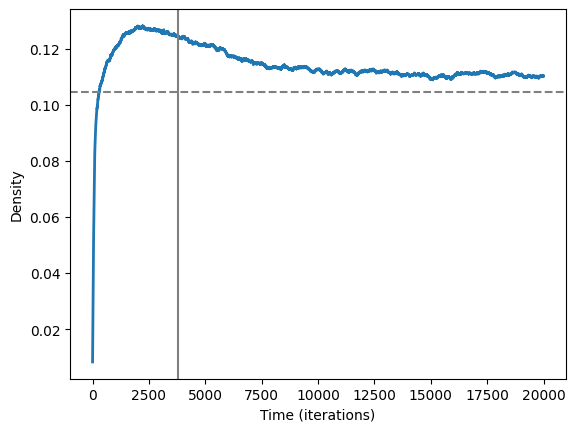

In [293]:
density = np.zeros(history.shape[2])
for t in tqdm(range(history.shape[2]), desc="Evaluating network evolution"):
    density[t] = nx.density(nx.from_numpy_array(history[:,:,t]))

plt.plot(density,lw=2)
plt.xlabel("Time (iterations)")
plt.ylabel("Density")
empirical_density = nx.density(nx.from_numpy_array(data))
plt.axhline(empirical_density, color='gray', linestyle='--')
plt.axvline(np.argmin(energy_vector), color='gray', linestyle='-')


In [88]:
import seaborn as sns

In [89]:
history[:,:,-1].astype(int).shape

(242, 242)

In [90]:
data.astype(int).shape

(242, 242)

/var/folders/49/t2b_h4w17d12qz0yb3dz34jm00076x/T/ipykernel_3392/1531759925.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


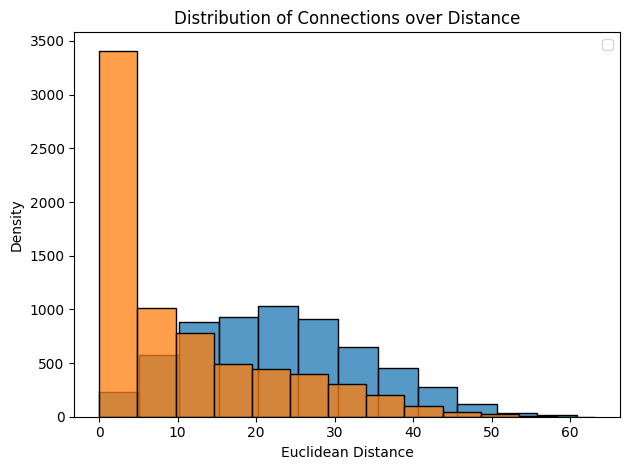

In [270]:
sns.histplot(macaque_euclidean_dist[data],binwidth=5)
what = history[:,:,-1].astype(bool)
sns.histplot(macaque_euclidean_dist[what],binwidth=5)

plt.xlabel('Euclidean Distance')
plt.ylabel('Density')
plt.title('Distribution of Connections over Distance')
plt.legend()

plt.tight_layout()

In [95]:
what

array([[0., 1., 1., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       [1., 1., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 1., 1.],
       [0., 0., 0., ..., 1., 0., 1.],
       [0., 0., 0., ..., 1., 1., 0.]])

In [96]:
connectivity

array([[False,  True,  True, ..., False, False, False],
       [ True, False, False, ..., False, False, False],
       [ True, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False,  True,  True],
       [False, False, False, ...,  True, False,  True],
       [False, False, False, ...,  True,  True, False]])